# 사전설정

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

## 종목 설정

In [ ]:
tickers = {
        'KODEX 200': '069500.KS',
        'KODEX 국고채10년': '152380.KS',
        'TIGER S&P500': '360750.KS',
        'KODEX 골드선물(H)': '132030.KS',
}

# 데이터 로드

In [10]:
# 변동성 계산을 위해 백테스트 시작 기간보다 넉넉하게 데이터 로드
start_date = '2023-11-01'
end_date = '2024-12-31'
backtest_start_date = '2024-01-01' # 실제 백테스트 시작일
initial_capital = 100000000 # 초기 자본금 1억원
volatility_window = 20 # 변동성 계산 기간 (20 거래일)

try:
    # 데이터 다운로드
    raw_data = yf.download(list(tickers.values()), start=start_date, end=end_date, progress=False, auto_adjust=False)
    
    # Close 가격 추출 (Adj Close가 없으므로 Close 사용)
    data = raw_data['Close'].copy()
    
    # 컬럼명을 티커명으로 변경
    data.columns = tickers.keys()
    
    if data.isnull().values.any():
        print("데이터에 누락된 값이 있어 채워넣습니다.")
        data.fillna(method='ffill', inplace=True)
    
    print("데이터 다운로드 성공!")
    print(f"데이터 형태: {data.shape}")
    print(f"\n최근 5행:\n{data.tail()}")
    
except Exception as e:
    print(f"데이터 다운로드 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()


데이터 다운로드 성공!
데이터 형태: (281, 4)

최근 5행:
            KODEX 200  KODEX 국고채10년  TIGER S&P500  KODEX 골드선물
Date                                                         
2024-12-23    32400.0       15970.0       69450.0     21565.0
2024-12-24    32425.0       15905.0       69165.0     21665.0
2024-12-26    32235.0       15965.0       69020.0     22055.0
2024-12-27    32145.0       16015.0       69000.0     22015.0
2024-12-30    32060.0       15915.0       69065.0     21905.0


# 백테스트 수행

In [79]:
# 2024년 데이터만 필터링
backtest_data = data.loc[backtest_start_date:]
    
# 월별 리밸런싱 날짜 생성
rebalance_dates = backtest_data.resample('M').last().index
    
portfolio_value = initial_capital
portfolio_history = pd.Series(index=backtest_data.index)
is_first_month = True

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28716\1882108093.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = backtest_data.resample('M').last().index


## 전략 검증 포인트
- ✅ **투자 유니버스**: 4개 ETF (주식, 채권, 금, 글로벌주식)
- ✅ **신호**: 역변동성 가중 (20일 변동성 기준)
- ✅ **리밸런싱 시점**: 매월 마지막 거래일 장 마감 후
- ✅ **적용 시점**: 리밸런싱 다음 영업일부터 새로운 가중치 적용
- ✅ **비중 계산**: 변동성이 낮은 자산에 높은 비중 (비중 ∝ 1/변동성)
- ✅ **정규화**: 가중치 합계 = 100%

In [80]:
# 리밸런싱 루프 실행
for i in range(len(rebalance_dates)):
    rebal_date = rebalance_dates[i]

    # 매월 마지막 거래일 종가 기준으로 변동성 계산
    hist_data = data.loc[:rebal_date].tail(volatility_window + 1)
    daily_returns = hist_data.pct_change().dropna()

    # 변동성 계산 및 역변동성 가중치 산출
    volatilities = daily_returns.std()
    inv_vols = 1 / volatilities
    weights = inv_vols / inv_vols.sum()
    
    print(f"\n[{rebal_date.strftime('%Y-%m-%d')}] 리밸런싱 (장 마감 후)")
    print(f"변동성(%): {(volatilities * 100).round(2).to_dict()}")
    print(f"투자 비중(%): {(weights * 100).round(2).to_dict()}")

    # 리밸런싱 적용 기간 설정
    # 리밸런싱 다음 영업일부터 다음 리밸런싱 날까지 해당 가중치 유지
    start_period = rebal_date + pd.Timedelta(days=1)
    
    if i < len(rebalance_dates) - 1:
        # 다음 리밸런싱 날까지
        end_period = rebalance_dates[i+1]
    else:
        # 마지막 리밸런싱: 백테스트 종료일까지
        end_period = backtest_data.index[-1]
    
    # 실제 거래일만 필터링
    period_data = backtest_data.loc[start_period:end_period]
    
    if len(period_data) == 0:
        print(f"  ⚠ 적용 기간 데이터 없음 (리밸런싱 후 영업일 없음)")
        continue
    
    # 해당 기간의 자산 가치 계산
    if i == 0:
        # 첫 리밸런싱: 리밸런싱 날의 종가 기준 평가액 사용
        # 백테스트 시작일 이전에 이미 포트폴리오를 구성했다고 가정
        temp_value = initial_capital
    else:
        # 이전 기간의 마지막 포트폴리오 가치 사용 (리밸런싱 날의 평가액)
        if rebal_date in portfolio_history.index:
            temp_value = portfolio_history.loc[rebal_date]
        else:
            # 리밸런싱 날짜가 없으면 가장 최근 값 사용
            available_dates = portfolio_history.dropna().index
            if len(available_dates) > 0:
                last_date = available_dates[-1]
                temp_value = portfolio_history.loc[last_date]
            else:
                temp_value = initial_capital

    # 자산 배분: 리밸런싱 후 첫 영업일 시가로 매수
    asset_shares = (temp_value * weights) / period_data.iloc[0]
    
    # 일별 포트폴리오 가치 계산
    portfolio_daily_value = (period_data * asset_shares).sum(axis=1)
    
    # 포트폴리오 히스토리에 저장
    portfolio_history.loc[period_data.index] = portfolio_daily_value
    
    print(f"  → 적용 기간: {period_data.index[0].strftime('%Y-%m-%d')} ~ {period_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"  → 리밸런싱 기준 평가액: {temp_value:,.0f}원")
    print(f"  → 기간 종료 평가액: {portfolio_daily_value.iloc[-1]:,.0f}원")
    print(f"  → 기간 수익률: {(portfolio_daily_value.iloc[-1]/temp_value - 1)*100:+.2f}%")



[2024-01-31] 리밸런싱 (장 마감 후)
변동성(%): {'KODEX 200': 1.09, 'KODEX 국고채10년': 0.57, 'TIGER S&P500': 0.35, 'KODEX 골드선물': 0.52}
투자 비중(%): {'KODEX 200': 12.31, 'KODEX 국고채10년': 23.71, 'TIGER S&P500': 38.13, 'KODEX 골드선물': 25.86}
  → 적용 기간: 2024-02-01 ~ 2024-02-29
  → 리밸런싱 기준 평가액: 100,000,000원
  → 기간 종료 평가액: 101,179,614원
  → 기간 수익률: +1.18%

[2024-02-29] 리밸런싱 (장 마감 후)
변동성(%): {'KODEX 200': 1.2, 'KODEX 국고채10년': 0.58, 'TIGER S&P500': 0.34, 'KODEX 골드선물': 0.7}
투자 비중(%): {'KODEX 200': 11.99, 'KODEX 국고채10년': 24.67, 'TIGER S&P500': 42.79, 'KODEX 골드선물': 20.56}
  → 적용 기간: 2024-03-04 ~ 2024-03-29
  → 리밸런싱 기준 평가액: 101,179,614원
  → 기간 종료 평가액: 104,488,920원
  → 기간 수익률: +3.27%

[2024-03-31] 리밸런싱 (장 마감 후)
변동성(%): {'KODEX 200': 1.1, 'KODEX 국고채10년': 0.97, 'TIGER S&P500': 0.28, 'KODEX 골드선물': 0.66}
투자 비중(%): {'KODEX 200': 12.88, 'KODEX 국고채10년': 14.56, 'TIGER S&P500': 51.23, 'KODEX 골드선물': 21.33}
  → 적용 기간: 2024-04-01 ~ 2024-04-30
  → 리밸런싱 기준 평가액: 104,488,920원
  → 기간 종료 평가액: 102,995,462원
  → 기간 수익률: -1.43%

[2024-04-30]

In [81]:
 # 4. 성과 분석
portfolio_df = portfolio_history.dropna().to_frame('Portfolio')
portfolio_df['Daily_Return'] = portfolio_df['Portfolio'].pct_change()

final_value = portfolio_df['Portfolio'].iloc[-1]
cagr = ((final_value / initial_capital) ** (365.0 / len(portfolio_df))) - 1

rolling_max = portfolio_df['Portfolio'].cummax()
daily_drawdown = portfolio_df['Portfolio'] / rolling_max - 1.0
mdd = daily_drawdown.min()

In [82]:
# 무위험 수익률 0% 가정
sharpe_ratio = portfolio_df['Daily_Return'].mean() / portfolio_df['Daily_Return'].std() * np.sqrt(252)

print(f"초기 자산: {initial_capital:,.0f} 원")
print(f"최종 자산: {final_value:,.0f} 원")
print(f"CAGR (연율화 수익률): {cagr:.2%}")
print(f"MDD (최대 낙폭): {mdd:.2%}")
print(f"Sharpe Ratio (샤프 지수): {sharpe_ratio:.2f}\n")

초기 자산: 100,000,000 원
최종 자산: 110,521,484 원
CAGR (연율화 수익률): 18.14%
MDD (최대 낙폭): -3.81%
Sharpe Ratio (샤프 지수): 1.91



# 성과 시각화

In [83]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import font_manager, rc

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

## 1. 포트폴리오 가치 추이

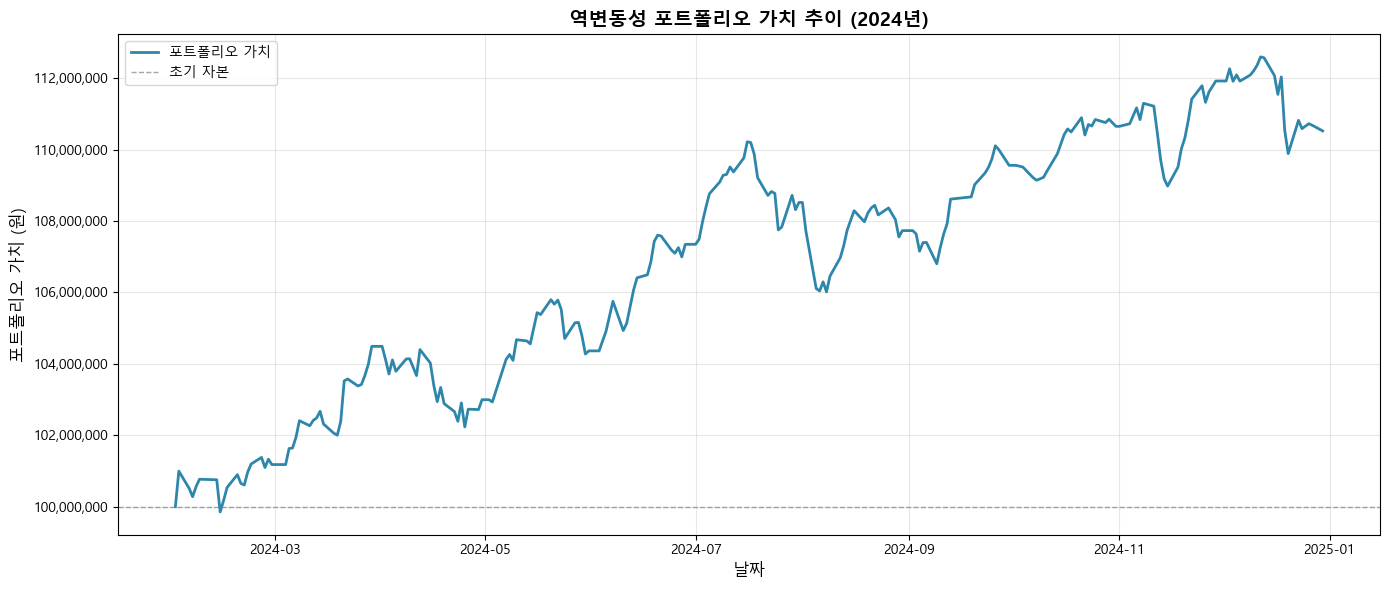

In [84]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(portfolio_df.index, portfolio_df['Portfolio'], linewidth=2, color='#2E86AB', label='포트폴리오 가치')
ax.axhline(y=initial_capital, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='초기 자본')

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('포트폴리오 가치 (원)', fontsize=12)
ax.set_title('역변동성 포트폴리오 가치 추이 (2024년)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 금액 포맷 설정
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

## 2. 누적 수익률 추이

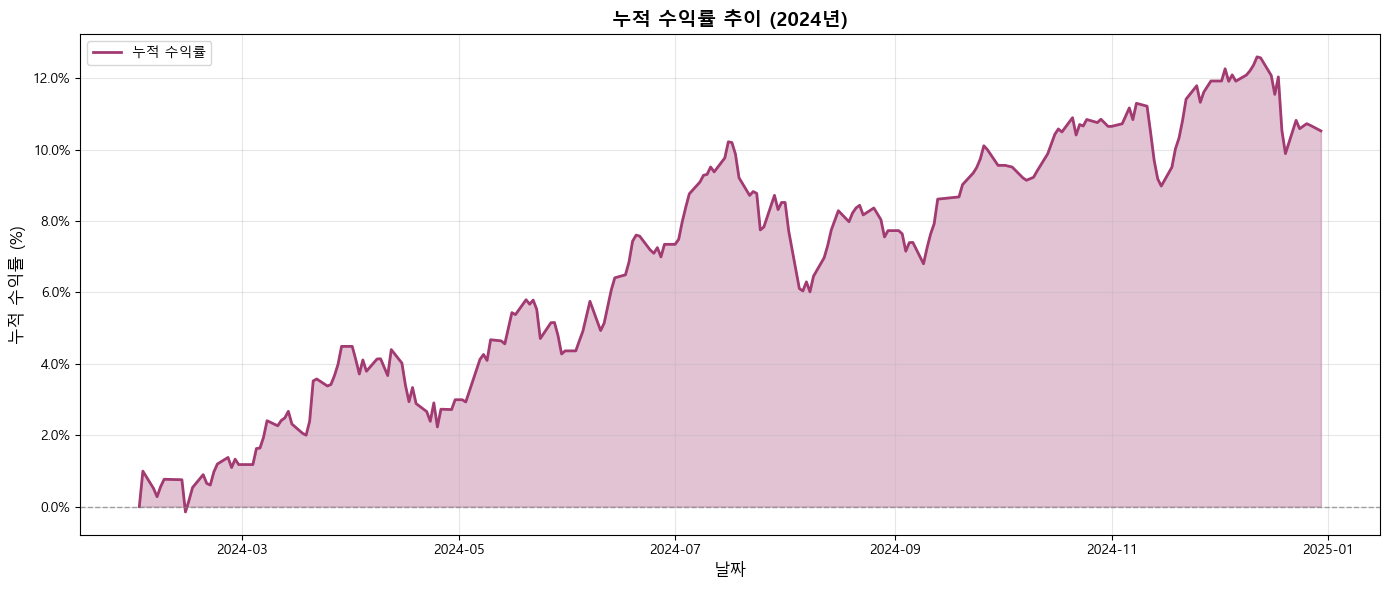

In [85]:
cumulative_returns = (portfolio_df['Portfolio'] / initial_capital - 1) * 100

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(portfolio_df.index, cumulative_returns, linewidth=2, color='#A23B72', label='누적 수익률')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.fill_between(portfolio_df.index, 0, cumulative_returns, alpha=0.3, color='#A23B72')

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('누적 수익률 (%)', fontsize=12)
ax.set_title('누적 수익률 추이 (2024년)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 퍼센트 포맷 설정
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

plt.tight_layout()
plt.show()

## 3. 낙폭(Drawdown) 분석

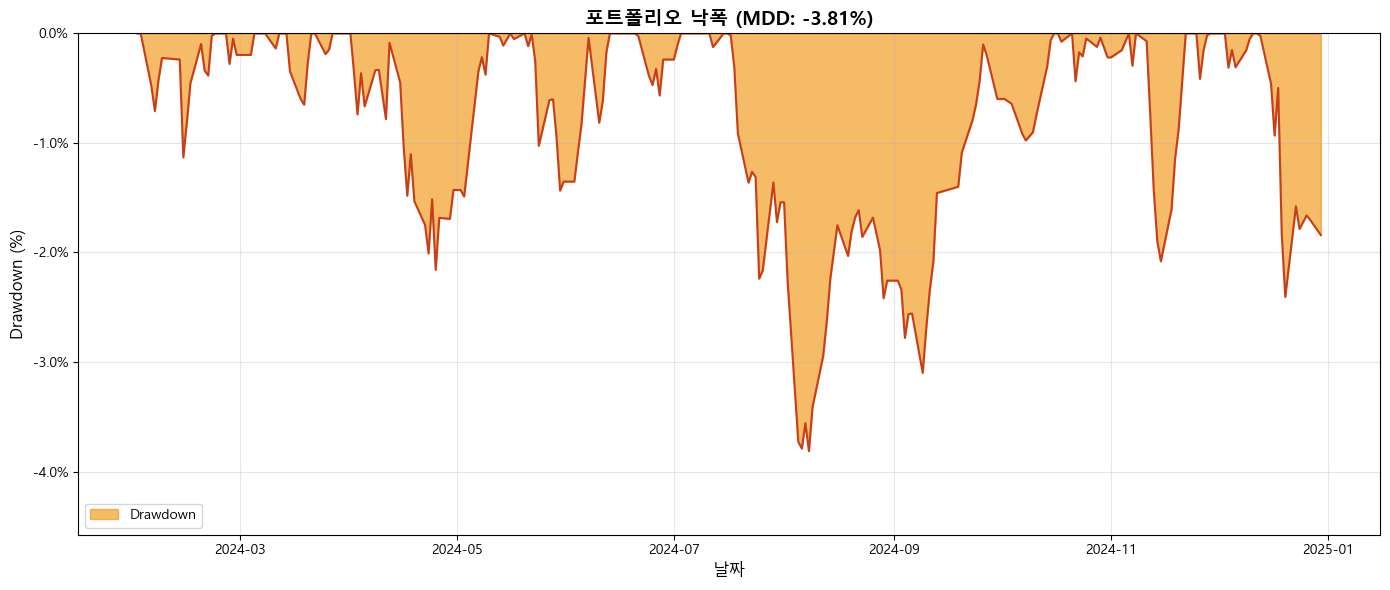

In [94]:
fig, ax = plt.subplots(figsize=(14, 6))

drawdown_pct = daily_drawdown * 100
ax.fill_between(portfolio_df.index, 0, drawdown_pct, color='#F18F01', alpha=0.6, label='Drawdown')
ax.plot(portfolio_df.index, drawdown_pct, linewidth=1.5, color='#C73E1D')

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.set_title(f'포트폴리오 낙폭 (MDD: {mdd:.2%})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# y축 범위 설정 (최소값보다 약간 더 여유있게)
y_min = min(drawdown_pct.min() * 1.2, -1)  # 최소 -1% 표시
ax.set_ylim(y_min, 0)  # 위쪽 여백 0.5%

# 퍼센트 포맷 설정
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

plt.tight_layout()
plt.show()

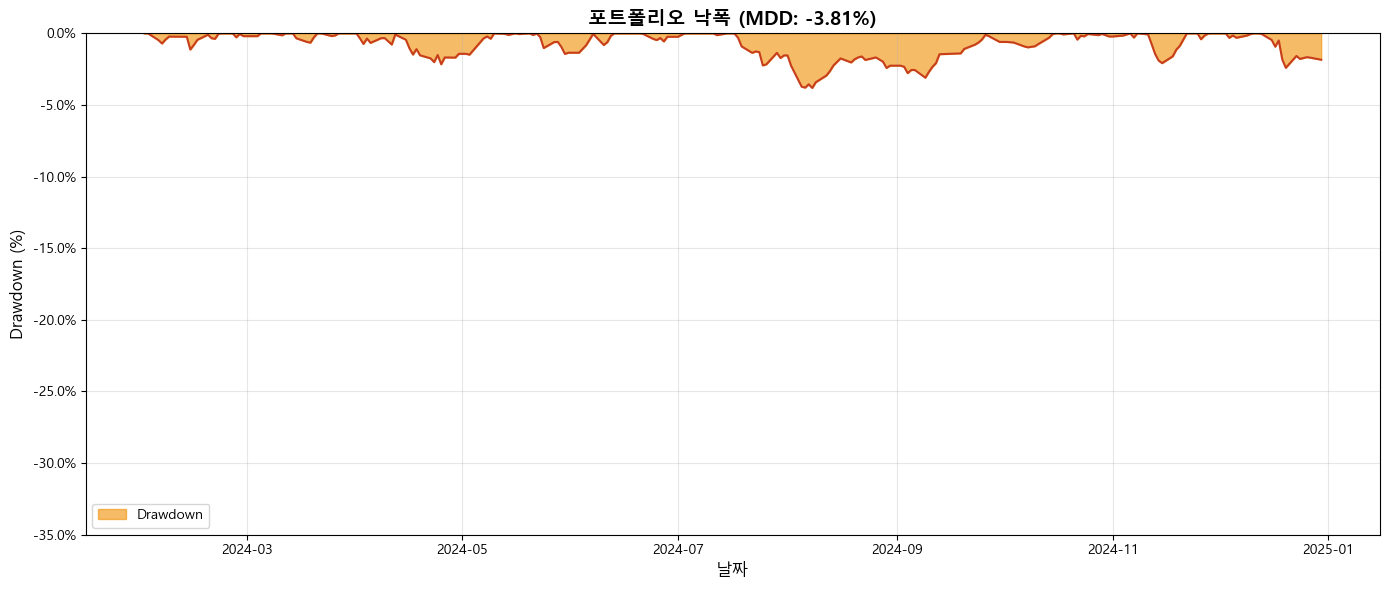

In [95]:
fig, ax = plt.subplots(figsize=(14, 6))

drawdown_pct = daily_drawdown * 100
ax.fill_between(portfolio_df.index, 0, drawdown_pct, color='#F18F01', alpha=0.6, label='Drawdown')
ax.plot(portfolio_df.index, drawdown_pct, linewidth=1.5, color='#C73E1D')

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.set_title(f'포트폴리오 낙폭 (MDD: {mdd:.2%})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# y축 범위 설정 (최소값보다 약간 더 여유있게)
ax.set_ylim(-35, 0)

# 퍼센트 포맷 설정
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

plt.tight_layout()
plt.show()

## 4. 일별 수익률 분포

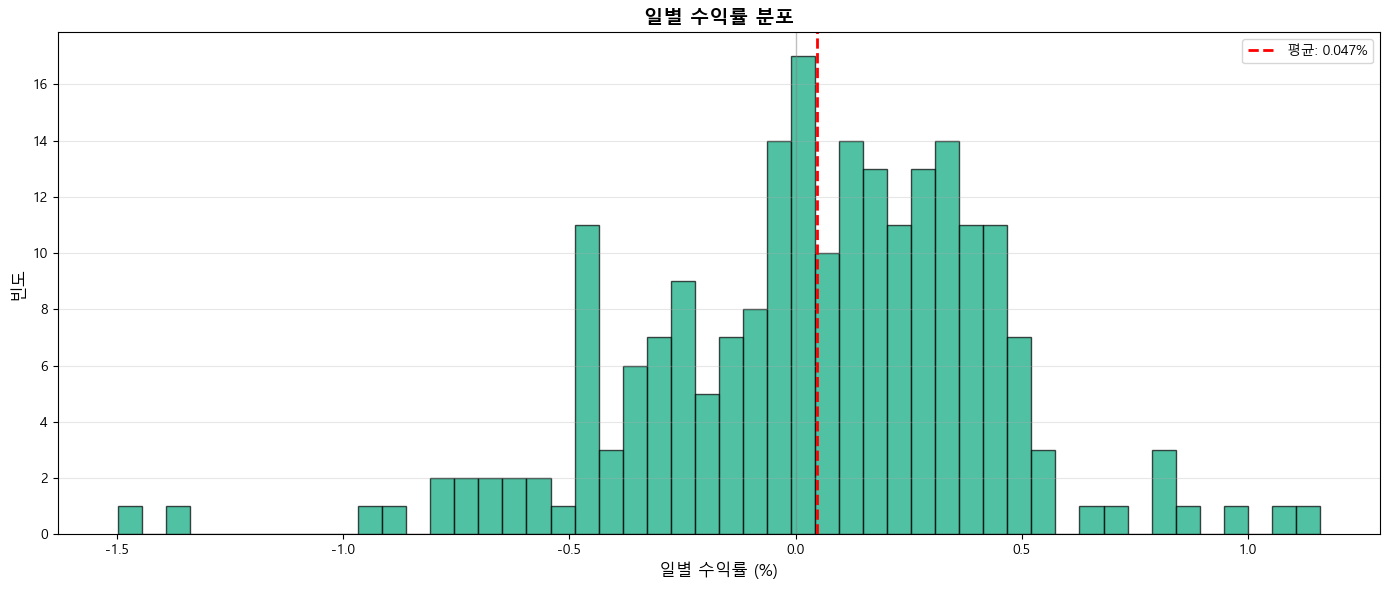

일별 수익률 통계:
  평균: 0.0466%
  표준편차: 0.3870%
  최대: 1.1586%
  최소: -1.4980%


In [87]:
daily_returns_pct = portfolio_df['Daily_Return'].dropna() * 100

fig, ax = plt.subplots(figsize=(14, 6))

ax.hist(daily_returns_pct, bins=50, color='#06A77D', alpha=0.7, edgecolor='black')
ax.axvline(daily_returns_pct.mean(), color='red', linestyle='--', linewidth=2, label=f'평균: {daily_returns_pct.mean():.3f}%')
ax.axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

ax.set_xlabel('일별 수익률 (%)', fontsize=12)
ax.set_ylabel('빈도', fontsize=12)
ax.set_title('일별 수익률 분포', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"일별 수익률 통계:")
print(f"  평균: {daily_returns_pct.mean():.4f}%")
print(f"  표준편차: {daily_returns_pct.std():.4f}%")
print(f"  최대: {daily_returns_pct.max():.4f}%")
print(f"  최소: {daily_returns_pct.min():.4f}%")

## 5. 월별 수익률

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28716\3062344622.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = portfolio_df['Portfolio'].resample('M').last().pct_change().dropna() * 100


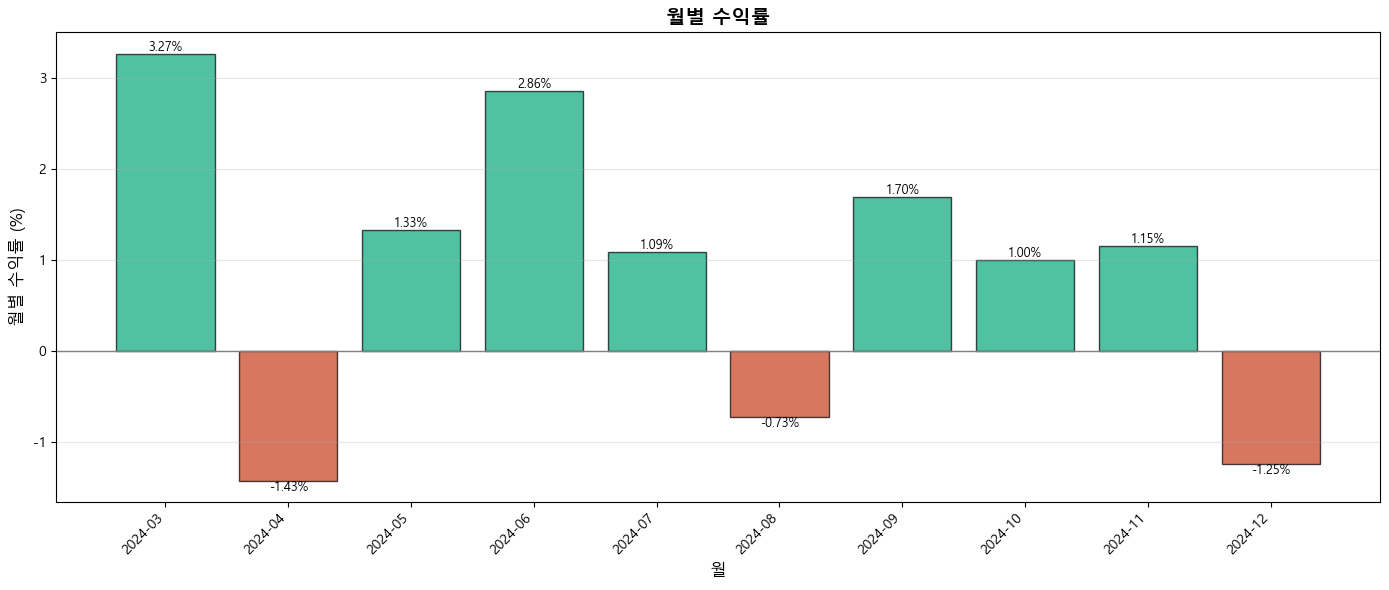

In [88]:
# 월별 수익률 계산
monthly_returns = portfolio_df['Portfolio'].resample('M').last().pct_change().dropna() * 100

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#06A77D' if x >= 0 else '#C73E1D' for x in monthly_returns]
bars = ax.bar(range(len(monthly_returns)), monthly_returns, color=colors, alpha=0.7, edgecolor='black')

ax.set_xlabel('월', fontsize=12)
ax.set_ylabel('월별 수익률 (%)', fontsize=12)
ax.set_title('월별 수익률', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='y')

# x축 레이블 설정
months = [date.strftime('%Y-%m') for date in monthly_returns.index]
ax.set_xticks(range(len(monthly_returns)))
ax.set_xticklabels(months, rotation=45, ha='right')

# 막대 위에 값 표시
for i, (bar, val) in enumerate(zip(bars, monthly_returns)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}%', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()